In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Распознавание категории обращения граждан по тексту обращения

In [2]:
!wget 'https://github.com/a18091986/MachineLearning/blob/main/Datasets/%D0%B1%D0%B0%D0%B7%D0%B0%20%D0%BE%D0%B1%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD.csv?raw=true' -O df.csv

--2022-05-04 19:17:30--  https://github.com/a18091986/MachineLearning/blob/main/Datasets/%D0%B1%D0%B0%D0%B7%D0%B0%20%D0%BE%D0%B1%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD.csv?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/a18091986/MachineLearning/raw/main/Datasets/%D0%B1%D0%B0%D0%B7%D0%B0%20%D0%BE%D0%B1%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD.csv [following]
--2022-05-04 19:17:30--  https://github.com/a18091986/MachineLearning/raw/main/Datasets/%D0%B1%D0%B0%D0%B7%D0%B0%20%D0%BE%D0%B1%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/a18091986/MachineLearning

In [3]:
df = pd.read_csv('df.csv')
df = df.iloc[:, :2]
df.head()

,text,category
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ
2,""" Спасибо Вам огромное за возобновление строит...",Строительство
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт
4,Некоторое время назад для школьников и студент...,Дороги и транспорт


In [4]:
df.shape

(10059, 2)

In [5]:
df.values[0]

array(['Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .',
       'Дороги и транспорт'], dtype=object)

In [6]:
for cat in df['category'].unique():
  print(f'записей по категории {cat}: {df[df["category"] == cat].shape[0]}')

записей по категории Дороги и транспорт: 1411
записей по категории ЖКХ: 2063
записей по категории Строительство: 349
записей по категории Спорт: 246
записей по категории Благо­­устрой­­ство: 1686
записей по категории Образование и наука: 290
записей по категории Культура: 100
записей по категории Демография: 20
записей по категории Социальная сфера: 370
записей по категории Другое: 208
записей по категории Бизнес: 187
записей по категории Здравоохранение: 368
записей по категории Органы власти: 244
записей по категории Экология: 180
записей по категории Правопорядок: 172
записей по категории Труд и занятость населения: 151
записей по категории Борьба с коррупцией: 59
записей по категории Промышленность: 13
записей по категории Сельское хозяйство: 50
записей по категории Земельные отношения: 80
записей по категории Туризм: 15
записей по категории nan: 0


In [7]:
texts = df['text'].values
classes = list(df['category'].values)
nClasses = df['category'].nunique() + 1

maxWordsCount = 50000

len(texts), len(classes), nClasses

(10059, 10059, 22)

In [8]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts)
xAll = tokenizer.texts_to_matrix(texts)
xAll.shape

(10059, 50000)

In [9]:
len(tokenizer.word_index.items()), tokenizer.word_index.items()

(80591,
 dict_items([('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('не', 5), ('с', 6), ('по', 7), ('что', 8), ('а', 9), ('к', 10), ('за', 11), ('я', 12), ('но', 13), ('как', 14), ('для', 15), ('от', 16), ('у', 17), ('это', 18), ('мы', 19), ('так', 20), ('все', 21), ('дома', 22), ('из', 23), ('нет', 24), ('то', 25), ('о', 26), ('до', 27), ('года', 28), ('очень', 29), ('нас', 30), ('ул', 31), ('уже', 32), ('г', 33), ('прошу', 34), ('№', 35), ('области', 36), ('нам', 37), ('только', 38), ('было', 39), ('же', 40), ('мне', 41), ('день', 42), ('бы', 43), ('вам', 44), ('лет', 45), ('при', 46), ('липецкой', 47), ('время', 48), ('ни', 49), ('здравствуйте', 50), ('меня', 51), ('города', 52), ('т', 53), ('дом', 54), ('есть', 55), ('вас', 56), ('они', 57), ('если', 58), ('или', 59), ('д', 60), ('после', 61), ('детей', 62), ('будет', 63), ('которые', 64), ('во', 65), ('чтобы', 66), ('без', 67), ('их', 68), ('где', 69), ('там', 70), ('улице', 71), ('когда', 72), ('этом', 73), ('добрый', 74), ('был

In [10]:
encoder = LabelEncoder()
encoder.fit(classes)
classesEncoded = encoder.transform(classes)
encoder.classes_, classesEncoded.shape

(array(['nan', 'Бизнес', 'Благо\xad\xadустрой\xad\xadство',
        'Борьба с коррупцией', 'Демография', 'Дороги и транспорт',
        'Другое', 'ЖКХ', 'Здравоохранение', 'Земельные отношения',
        'Культура', 'Образование и наука', 'Органы власти', 'Правопорядок',
        'Промышленность', 'Сельское хозяйство', 'Социальная сфера',
        'Спорт', 'Строительство', 'Труд и занятость населения', 'Туризм',
        'Экология'], dtype='<U32'), (10059,))

In [11]:
yAll = utils.to_categorical(classesEncoded, nClasses)
yAll.shape
yAll[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [12]:
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size = 0.2, shuffle = True)

In [13]:
sequences = tokenizer.texts_to_sequences(texts)
xTrainE, xValE, yTrainE, yValE = train_test_split(np.array(sequences), yAll, test_size = 0.2, shuffle = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch 1/20
63/63 [==============================] - 9s 124ms/step - loss: 2.5215 - accuracy: 0.2257 - val_loss: 1.9250 - val_accuracy: 0.4578
Epoch 2/20
63/63 [==============================] - 7s 112ms/step - loss: 1.8251 - accuracy: 0.4313 - val_loss: 1.6781 - val_accuracy: 0.4801
Epoch 3/20
63/63 [==============================] - 7s 115ms/step - loss: 1.3901 - accuracy: 0.5690 - val_loss: 1.5965 - val_accuracy: 0.5224
Epoch 4/20
63/63 [==============================] - 8s 119ms/step - loss: 1.0545 - accuracy: 0.6894 - val_loss: 1.6346 - val_accuracy: 0.5348
Epoch 5/20
63/63 [==============================] - 8s 119ms/step - loss: 0.8138 - accuracy: 0.7626 - val_loss: 1.7451 - val_accuracy: 0.5358
Epoch 6/20
63/63 [==============================] - 7s 114ms/step - loss: 0.6524 - accuracy: 0.8065 - val_loss: 1.8276 - val_accuracy: 0.5512
Epoch 7/20
63/63 [==============================] - 7s 113ms/step - loss: 0.5478 - accuracy: 0.8450 - val_loss: 1.9370 - val_accuracy: 0.5557
Epoch 

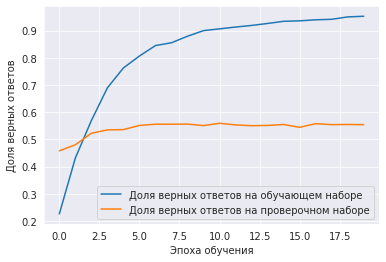

In [15]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Второй полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Третий полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Выходной полносвязный слой
model01.add(Dense(nClasses, activation='softmax'))


model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

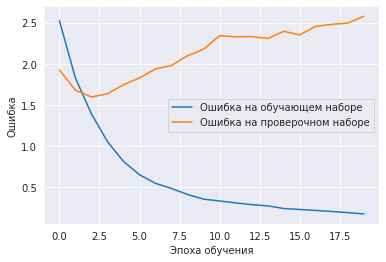

In [16]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

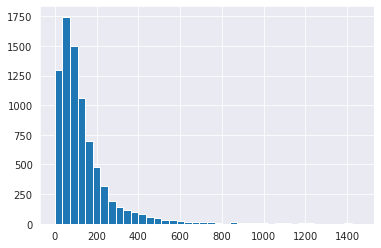

In [17]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [18]:
maxlen = 400

xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы

In [19]:
print(xTrainE.shape)

(8047, 400)


Epoch 1/15
161/161 [==============================] - 15s 84ms/step - loss: 3.1111 - accuracy: 0.1496 - val_loss: 2.5976 - val_accuracy: 0.2366
Epoch 2/15
161/161 [==============================] - 13s 79ms/step - loss: 1.7184 - accuracy: 0.5035 - val_loss: 2.3541 - val_accuracy: 0.2729
Epoch 3/15
161/161 [==============================] - 12s 77ms/step - loss: 0.6797 - accuracy: 0.8293 - val_loss: 2.0910 - val_accuracy: 0.3748
Epoch 4/15
161/161 [==============================] - 12s 75ms/step - loss: 0.2808 - accuracy: 0.9448 - val_loss: 2.0523 - val_accuracy: 0.3877
Epoch 5/15
161/161 [==============================] - 12s 77ms/step - loss: 0.1408 - accuracy: 0.9760 - val_loss: 2.1286 - val_accuracy: 0.3882
Epoch 6/15
161/161 [==============================] - 13s 82ms/step - loss: 0.0875 - accuracy: 0.9866 - val_loss: 2.2158 - val_accuracy: 0.3852
Epoch 7/15
161/161 [==============================] - 12s 76ms/step - loss: 0.0639 - accuracy: 0.9907 - val_loss: 2.2646 - val_accuracy:

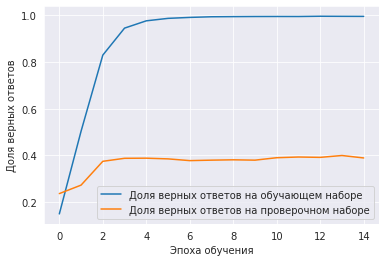

In [20]:
#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

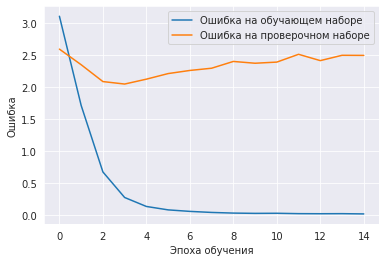

In [21]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [14]:
maxCountStrings = 400
minCountStrings = 300

df = df.dropna().reset_index()

for cat in df['category'].unique():
  initialLen = df[df.category == cat].shape[0]
  if (df[df.category == cat].shape[0] < minCountStrings):
    df = df.drop(df[df.category == cat].index)
  if (df[df.category == cat].shape[0] > maxCountStrings):
    df = df.drop(df[df.category == cat].index[maxCountStrings:])
  print(f'Количество записей класса {initialLen}. В выборку вошло: {df[df.category == cat].shape[0]}')


df = df.reset_index()

Количество записей класса 1411. В выборку вошло: 400
Количество записей класса 2063. В выборку вошло: 400
Количество записей класса 349. В выборку вошло: 349
Количество записей класса 246. В выборку вошло: 0
Количество записей класса 1686. В выборку вошло: 400
Количество записей класса 290. В выборку вошло: 0
Количество записей класса 100. В выборку вошло: 0
Количество записей класса 20. В выборку вошло: 0
Количество записей класса 370. В выборку вошло: 370
Количество записей класса 208. В выборку вошло: 0
Количество записей класса 187. В выборку вошло: 0
Количество записей класса 368. В выборку вошло: 368
Количество записей класса 244. В выборку вошло: 0
Количество записей класса 180. В выборку вошло: 0
Количество записей класса 172. В выборку вошло: 0
Количество записей класса 151. В выборку вошло: 0
Количество записей класса 59. В выборку вошло: 0
Количество записей класса 13. В выборку вошло: 0
Количество записей класса 50. В выборку вошло: 0
Количество записей класса 80. В выборку

In [57]:
texts = df['text'].values
classes = list(df['category'].values)

maxWordsCount = 20000
nClasses = df['category'].nunique() + 1
print(nClasses)
print(df['category'].unique())

7
['Дороги и транспорт' 'ЖКХ' 'Строительство'
 'Благо\xad\xadустрой\xad\xadство' 'Социальная сфера' 'Здравоохранение']


In [58]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
# tokenizer = Tokenizer(num_words=maxWordsCount, filters='')
tokenizer.fit_on_texts(texts)
xAll = tokenizer.texts_to_matrix(texts)
xAll.shape

(2287, 20000)

In [59]:
encoder = LabelEncoder()
classesEncoded = encoder.fit_transform(classes)
yAll = utils.to_categorical(classesEncoded, nClasses)
yAll.shape

(2287, 7)

In [60]:
x_train, x_val, y_train, y_val = train_test_split(xAll, yAll, test_size = 0.2)
xTrain.shape, yTrain.shape

((8047, 50000), (8047, 22))

In [61]:
Sequences = tokenizer.texts_to_sequences(texts)
npSequences = np.array(Sequences)
x_trainE, x_valE, y_trainE, y_valE = train_test_split(npSequences, yAll, test_size = 0.2)
x_trainE.shape, y_trainE.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


((1829,), (1829, 7))

In [85]:
model = Sequential()
model.add(Dense(64, input_dim = maxWordsCount, activation = 'relu'))
model.add(Dropout(0.45))
model.add(Dense(nClasses, activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

result = model.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/5
15/15 [==============================] - 3s 134ms/step - loss: 1.7861 - accuracy: 0.3226 - val_loss: 1.4913 - val_accuracy: 0.7314
Epoch 2/5
15/15 [==============================] - 1s 61ms/step - loss: 1.1953 - accuracy: 0.7709 - val_loss: 1.1027 - val_accuracy: 0.7969
Epoch 3/5
15/15 [==============================] - 1s 49ms/step - loss: 0.7937 - accuracy: 0.8775 - val_loss: 0.8950 - val_accuracy: 0.8100
Epoch 4/5
15/15 [==============================] - 1s 46ms/step - loss: 0.5553 - accuracy: 0.9207 - val_loss: 0.7804 - val_accuracy: 0.8275
Epoch 5/5
15/15 [==============================] - 1s 53ms/step - loss: 0.3998 - accuracy: 0.9535 - val_loss: 0.7163 - val_accuracy: 0.8231


In [86]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

result = model.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_data = (x_val, y_val))

Epoch 1/5
15/15 [==============================] - 1s 48ms/step - loss: 0.3294 - accuracy: 0.9645 - val_loss: 0.7104 - val_accuracy: 0.8275
Epoch 2/5
15/15 [==============================] - 1s 38ms/step - loss: 0.3130 - accuracy: 0.9699 - val_loss: 0.7040 - val_accuracy: 0.8275
Epoch 3/5
15/15 [==============================] - 1s 36ms/step - loss: 0.3038 - accuracy: 0.9732 - val_loss: 0.6981 - val_accuracy: 0.8210
Epoch 4/5
15/15 [==============================] - 1s 36ms/step - loss: 0.2931 - accuracy: 0.9754 - val_loss: 0.6916 - val_accuracy: 0.8231
Epoch 5/5
15/15 [==============================] - 1s 36ms/step - loss: 0.2891 - accuracy: 0.9688 - val_loss: 0.6859 - val_accuracy: 0.8210


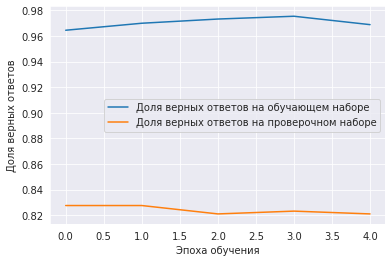

In [87]:
plt.plot(result.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(result.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

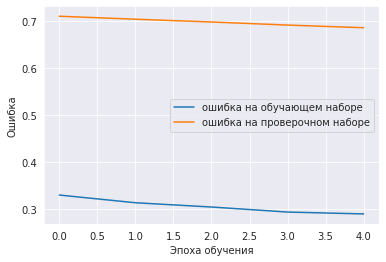

In [88]:
plt.plot(result.history['loss'], 
         label='ошибка на обучающем наборе')
plt.plot(result.history['val_loss'], 
         label='ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

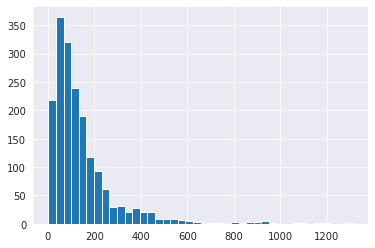

In [31]:
lenXTrainE = [len(x) for x in x_trainE]
plt.hist(lenXTrainE, 40)
plt.show()

Epoch 1/30
37/37 [==============================] - 4s 82ms/step - loss: 2.3780 - accuracy: 0.1684 - val_loss: 1.9052 - val_accuracy: 0.1681
Epoch 2/30
37/37 [==============================] - 3s 75ms/step - loss: 1.4389 - accuracy: 0.4893 - val_loss: 1.9511 - val_accuracy: 0.1681
Epoch 3/30
37/37 [==============================] - 3s 72ms/step - loss: 0.4785 - accuracy: 0.8797 - val_loss: 1.8619 - val_accuracy: 0.1703
Epoch 4/30
37/37 [==============================] - 2s 66ms/step - loss: 0.1801 - accuracy: 0.9798 - val_loss: 1.8199 - val_accuracy: 0.2598
Epoch 5/30
37/37 [==============================] - 3s 74ms/step - loss: 0.0887 - accuracy: 0.9940 - val_loss: 1.8074 - val_accuracy: 0.2751
Epoch 6/30
37/37 [==============================] - 3s 71ms/step - loss: 0.0554 - accuracy: 0.9973 - val_loss: 1.7939 - val_accuracy: 0.2773
Epoch 7/30
37/37 [==============================] - 3s 70ms/step - loss: 0.0366 - accuracy: 0.9989 - val_loss: 1.7783 - val_accuracy: 0.2576
Epoch 8/30
37

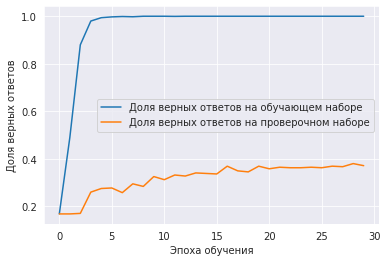

In [32]:
maxlen = 300

x_trainE = pad_sequences(x_trainE, maxlen=maxlen)
x_valE = pad_sequences(x_valE, maxlen=maxlen)

#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(x_trainE, 
                    y_trainE, 
                    epochs=30,
                    batch_size=50,
                    validation_data=(x_valE, y_valE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

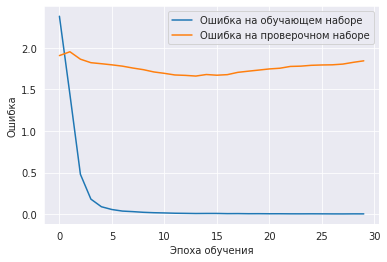

In [33]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()